##  1.将分类好的图片及其标签序号存入到TFRecord文件中

In [1]:
import os
import tensorflow as tf
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from pylab import *

#获取数据文件夹列表名
def file_name(file_dir):
    for root,dirs,files in os.walk(file_dir):
         return dirs    # 返回当前路径下所有子目录
file_dir = './data'     # 数据文件夹所在目录
labels_name=sorted(list(file_name(file_dir)))  #将保存数据的文件夹名形成一个有序列表列表
labels_name.remove('.ipynb_checkpoints')  #删除其中自动生成的'.ipynb_checkpoints'文件夹
cwd = os.getcwd() #定义一个当前目录
# labels_dict = {} # 定义一个字典

# for i in labels_name:   
#     labels_dict[labels_name.index(i)] = i   # 让labels_name中元素的下标作为键，下标对应的元素作为键值。
# labels = list(labels_dict.keys())  #将labels_dict的键组成一个列表作为标签类

### (1)train.tfrecord文件生成

In [6]:
import random
writer = tf.python_io.TFRecordWriter("./train.tfrecords")  # 创建一个test.tfrecords文件
for index, name in enumerate(labels_name):  #enumerate()函数用于将一个可遍历的数据对象(如列表、元组或字符串)组合为一个索引序列，同时列出数据和数据下标
    class_path = cwd + '/data/'+name+'/'  # 定义图片文件路径
    train_num = random.sample(os.listdir(class_path), int(0.7*len(os.listdir(class_path))))  # 从文件中选取50%的数据作为训练
    for img_name in train_num: # os.listdir() 方法用于返回指定的文件夹包含的文件或文件夹的名字的列表
        img_path = class_path + img_name    # 图片路径
        img = Image.open(img_path)  # 定义操作对象
        img = img.resize((24, 48)) # 将图片改为24*48
        img_raw = img.tobytes()              #将图片转化为原生bytes
        example = tf.train.Example(features = tf.train.Features(feature = {
                         "label": tf.train.Feature(int64_list=tf.train.Int64List(value = [index])),
                         'img_raw': tf.train.Feature(bytes_list=tf.train.BytesList(value = [img_raw]))
                         })) 
        writer.write(example.SerializeToString())  #序列化为字符串
writer.close()

###  2) validation .tfrecord文件的生成

In [3]:
writer = tf.python_io.TFRecordWriter("./validation.tfrecords")  # 创建一个validation.tfrecords文件
for index, name in enumerate(labels_name):  #enumerate()函数用于将一个可遍历的数据对象(如列表、元组或字符串)组合为一个索引序列，同时列出数据和数据下标
    class_path = cwd + '/data/'+name+'/'  # 定义图片文件路径
    train_num=random.sample(os.listdir(class_path), int(0.3*len(os.listdir(class_path))))  # 从文件中选取50%的数据作为训练集
    for img_name in train_num: # os.listdir() 方法用于返回指定的文件夹包含的文件或文件夹的名字的列表
        img_path = class_path + img_name    # 图片路径
        img = Image.open(img_path)  # 定义操作对象
        img = img.resize((24, 48)) # 将图片改为24*48
        img_raw = img.tobytes()              #将图片转化为原生bytes
        example = tf.train.Example(features=tf.train.Features(feature={
                         "label": tf.train.Feature(int64_list=tf.train.Int64List(value=[index])),
                         'img_raw': tf.train.Feature(bytes_list=tf.train.BytesList(value=[img_raw]))
                         }))
        writer.write(example.SerializeToString())  #序列化为字符串
writer.close()

## 2.读取TFRecord文件：数据解码;reshape(恢复数据形状);shuffle_batch;然后还有归一化处理、色彩空间变化、转换为灰色图片等操作。

(18,) (18, 48, 24, 1)
5


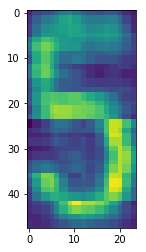

0


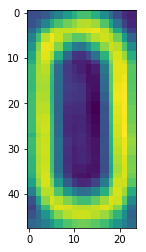

1


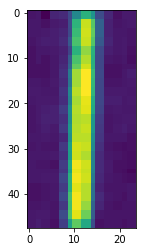

3


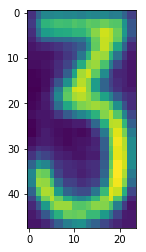

1


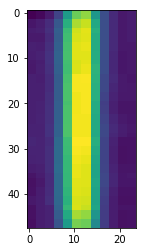

3


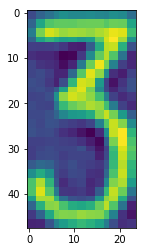

5


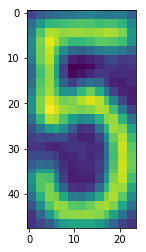

2


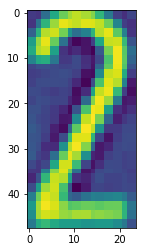

3


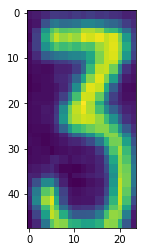

1


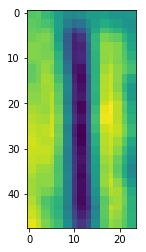

2


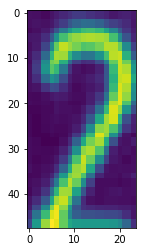

3


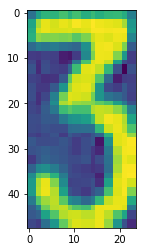

4


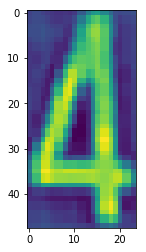

1


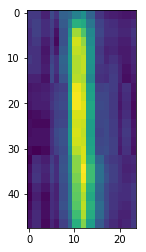

1


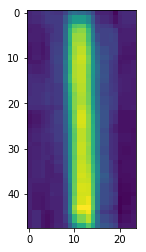

4


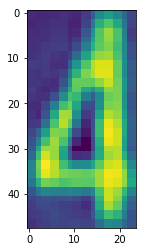

2


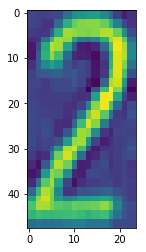

4


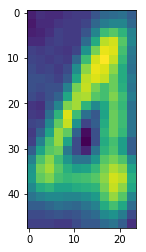

(18,) (18, 48, 24, 1)
2


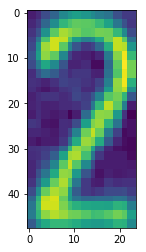

1


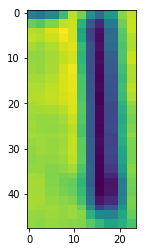

4


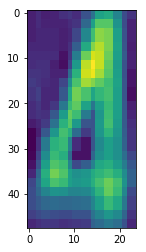

3


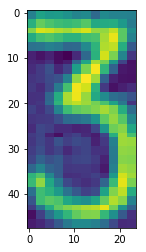

4


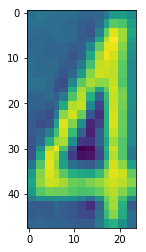

0


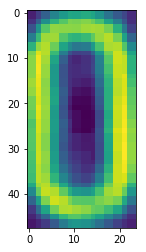

2


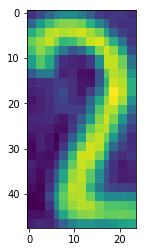

6


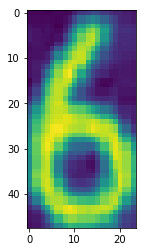

1


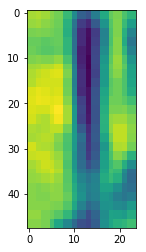

0


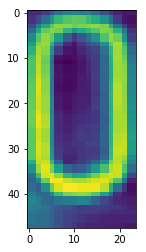

4


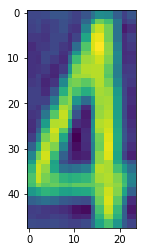

3


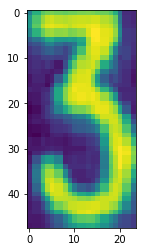

2


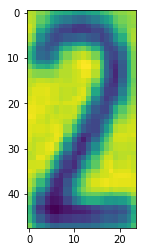

3


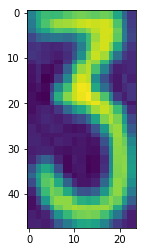

3


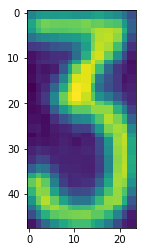

0


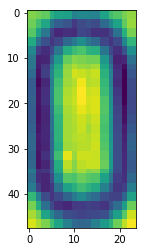

3


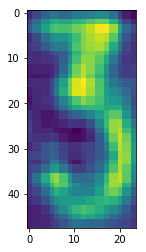

2


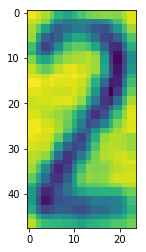

(18,) (18, 48, 24, 1)
0


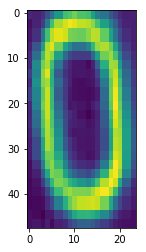

1


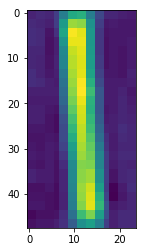

5


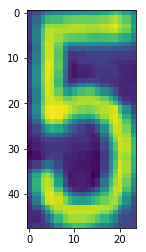

4


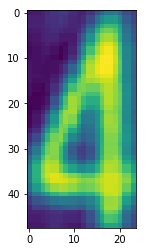

1


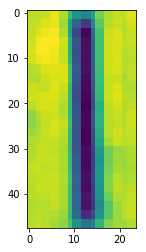

2


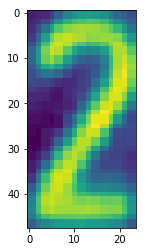

1


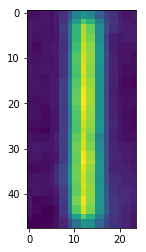

4


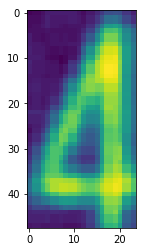

1


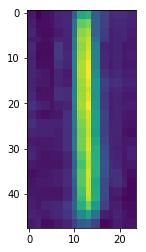

2


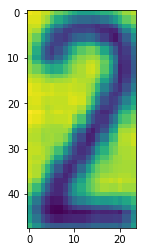

2


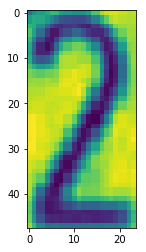

5


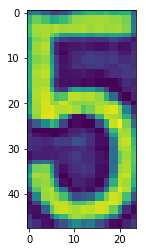

2


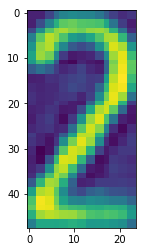

0


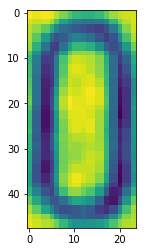

0


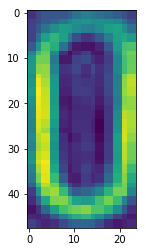

3


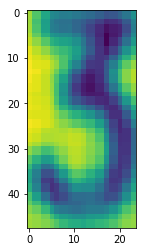

4


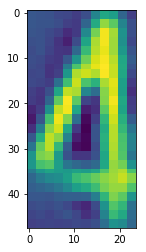

1


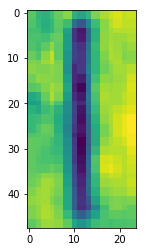

(18,) (18, 48, 24, 1)
5


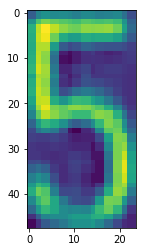

5


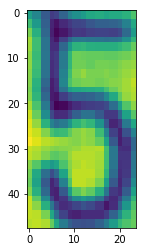

0


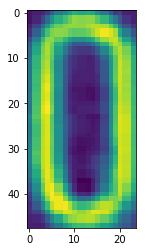

4


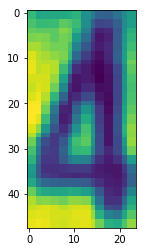

5


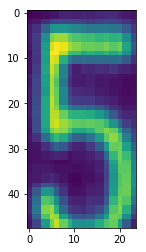

0


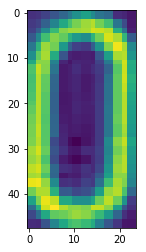

1


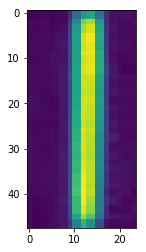

4


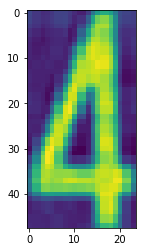

2


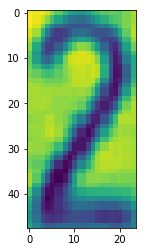

0


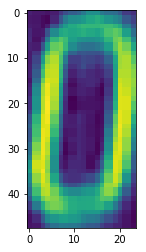

3


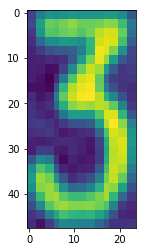

3


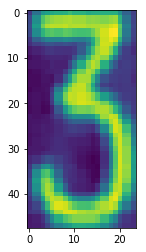

1


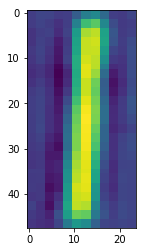

0


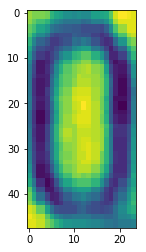

5


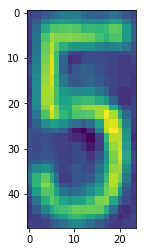

1


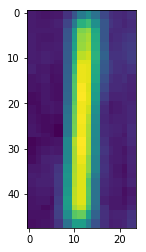

1


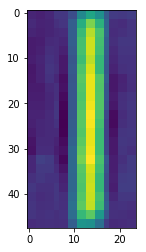

0


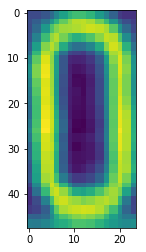

(18,) (18, 48, 24, 1)
3


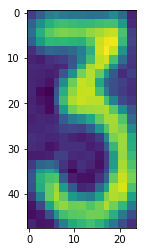

1


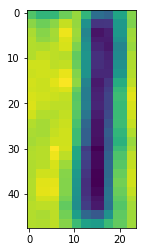

3


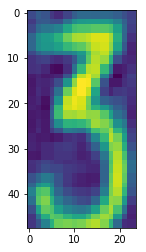

6


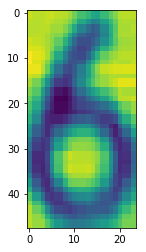

2


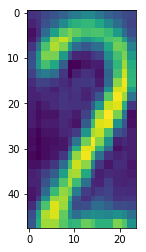

1


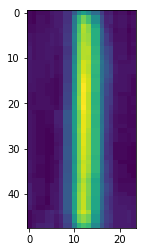

4


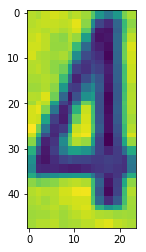

0


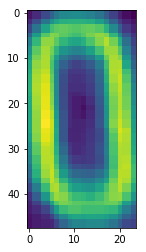

0


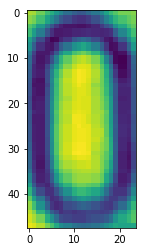

0


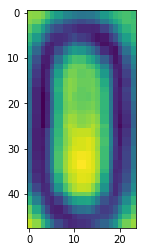

5


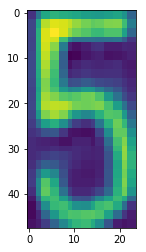

0


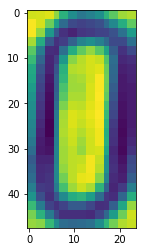

2


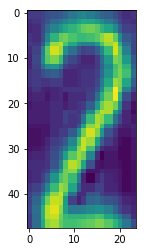

0


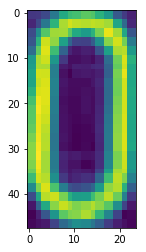

3


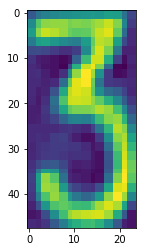

1


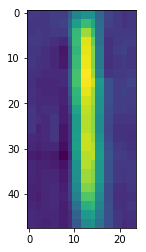

0


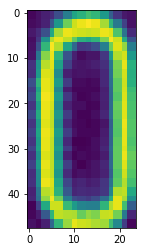

3


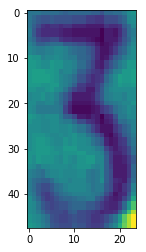

In [4]:
# 使用队列读取
def read_and_decode(filename):
    #根据文件名生成一个队列
    filename_queue = tf.train.string_input_producer([filename]) #选择要读取的文件的名字，用 tf.train.string_input_producer 函数来生成文件名队列，这个函数可以设置shuffle = Ture，来打乱队列，可以设置epoch = x，过x遍训练数据。
    reader = tf.TFRecordReader() #文件读取器
    _, serialized_example = reader.read(filename_queue)  #返回文件名和文件
    features = tf.parse_single_example(serialized_example, #通过解析器tf.parse_single_example解析
                                       features={
                                       'label': tf.FixedLenFeature([], tf.int64),
                                       'img_raw' : tf.FixedLenFeature([], tf.string),
                                       })
    image = tf.decode_raw(features['img_raw'], tf.uint8) #用解码器 tf.decode_raw 解码。
    image = tf.cast(image, dtype='float32')*(1/255)-0.5  # 归一化处理
    image = tf.reshape(image, [48, 24, 3]) # 恢复数据形状
    image = tf.split(image, 3, 2)[0]
    label = tf.cast(features['label'], tf.int32)
    return image, label


image, label = read_and_decode("train.tfrecords")


# shuffle_batch
image_batch, label_batch = tf.train.shuffle_batch([image,label], batch_size=18, capacity=2000, min_after_dequeue=1990, num_threads=2)  

init = tf.local_variables_initializer()

# 用训练集进行训练
with tf.Session() as sess:
    sess.run(init)
    coord = tf.train.Coordinator() #创建一个协调器，管理线程
    threads = tf.train.start_queue_runners(sess=sess, coord=coord)   #启动QueueRunner, 此时文件名队列已经进队
    for i in range(5):  # 规定出队数量
        img, label = sess.run([image_batch, label_batch])
        print(label.shape,img.shape)
        for j in range(18):
            print(label[j])
            im = img[j].reshape(48,24)
            plt.imshow(im)
            plt.show()
    coord.request_stop()
    coord.join(threads)